# Competition Goal

## Overview
Welcome to the 2025 Kaggle Playground Series! This competition aims to provide an engaging and approachable dataset for the community to practice their machine learning skills. Each month, we anticipate a new competition, and this month, we focus on predicting the optimal fertilizers for various weather, soil conditions, and crops.

## Your Goal
Your objective is to select the best fertilizer for different weather, soil conditions, and crops based on the provided dataset.

## Evaluation
Submissions are evaluated according to the **Mean Average Precision @ 3 (MAP@3)**, which is calculated using the following formula:

$
\text{MAP@3} = \frac{1}{N} \sum_{i=1}^{N} P@k
$
Where:
- \$ N \$ is the number of observations,
- \$ P@k \$ is the precision at cutoff \$ k \$,
- \$ k \$ is the number of predictions per observation,
- The indicator function equals 1 if the item at rank \$ k \$ is a relevant (correct) label, and zero otherwise.

# Imports

In [ ]:
!pip install category_encoders

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import typing

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import clone
from sklearn import metrics

In [4]:
import gc
import torch

In [6]:
warnings.filterwarnings('ignore')

# Data

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
paths = {}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        paths[filename] = path
        print(path)
paths
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


{'sample_submission.csv': '/kaggle/input/playground-series-s5e6/sample_submission.csv',
 'train.csv': '/kaggle/input/playground-series-s5e6/train.csv',
 'test.csv': '/kaggle/input/playground-series-s5e6/test.csv'}

In [10]:
!head -n 10 {paths['train.csv']}

id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP
5,30,59,29,Red,Pulses,10,0,9,20-20
6,27,62,53,Sandy,Paddy,26,15,22,28-28
7,36,62,44,Red,Pulses,30,12,35,14-35-14
8,36,51,32,Loamy,Tobacco,19,17,29,17-17-17


In [11]:
!head -n 10 {paths['test.csv']}

id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
750000,31,70,52,Sandy,Wheat,34,11,24
750001,27,62,45,Red,Sugarcane,30,14,15
750002,28,72,28,Clayey,Ground Nuts,14,15,4
750003,37,53,57,Black,Ground Nuts,18,17,36
750004,31,55,32,Red,Pulses,13,19,14
750005,35,63,34,Black,Millets,36,3,2
750006,38,50,56,Clayey,Sugarcane,32,6,31
750007,25,55,44,Black,Barley,32,9,32
750008,29,56,60,Red,Pulses,26,5,13


In [12]:
train_df = pd.read_csv(paths['train.csv'], index_col="id", header = 0)
test_df = pd.read_csv(paths['test.csv'], index_col = "id", header = 0)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      750000 non-null  int64 
 1   Humidity         750000 non-null  int64 
 2   Moisture         750000 non-null  int64 
 3   Soil Type        750000 non-null  object
 4   Crop Type        750000 non-null  object
 5   Nitrogen         750000 non-null  int64 
 6   Potassium        750000 non-null  int64 
 7   Phosphorous      750000 non-null  int64 
 8   Fertilizer Name  750000 non-null  object
dtypes: int64(6), object(3)
memory usage: 57.2+ MB


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Temparature  250000 non-null  int64 
 1   Humidity     250000 non-null  int64 
 2   Moisture     250000 non-null  int64 
 3   Soil Type    250000 non-null  object
 4   Crop Type    250000 non-null  object
 5   Nitrogen     250000 non-null  int64 
 6   Potassium    250000 non-null  int64 
 7   Phosphorous  250000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 17.2+ MB


There are 8 features and 2 of them are categorical ("**Soil Type**", "**Crop Type**"). The numerical features are integers

We have set the "id" column as index. Now let's check if there are unique indices for train and test

In [15]:
train_df.index.is_unique, test_df.index.is_unique

(True, True)

### Response Variable

The response variable is "**Fertilizer Name**". It is a categorical variable

In [16]:
train_df['Fertilizer Name'].value_counts(dropna=False, normalize=True).apply(lambda x : np.round(x,3))

Fertilizer Name
14-35-14    0.153
10-26-26    0.152
17-17-17    0.150
28-28       0.148
20-20       0.148
DAP         0.126
Urea        0.123
Name: proportion, dtype: float64

There are 7 unique classes, pretty balanced. <br>
So this is a multi-class classification problem. <br>
DAP and Urea have the smallest proportion in the total.

# EDA

### check for duplicates

In [17]:
train_df.duplicated().sum(), test_df.duplicated().sum()

(0, 0)

There don't appear to be duplicated rows - we are exluding the ids which we have set as index.

Take a look at how many classes the categorical variables have in the 2 datasets.

In [18]:
train_df.describe(include="object")

,Soil Type,Crop Type,Fertilizer Name
count,750000,750000,750000
unique,5,11,7
top,Sandy,Paddy,14-35-14
freq,156710,85754,114436


In [19]:
test_df.describe(include="object")

,Soil Type,Crop Type
count,250000,250000
unique,5,11
top,Sandy,Paddy
freq,52323,28332


Let's check the description of numerical features for both train and test to see if distributions differ

In [20]:
train_df.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [21]:
test_df.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.00000
mean,31.491648,61.045120,45.190444,23.139612,9.487764,21.12206
std,4.024093,6.636372,11.793167,11.215956,5.766860,12.38087
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.00000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.00000
50%,31.000000,61.000000,45.000000,23.000000,10.000000,21.00000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.00000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.00000


Numerical variables seem to be almost identically distributed between Train and Test.
Another observation is that the minimum values for Potassium and Phosphorous is zero(0).

## Distribution plots

### Target Variable

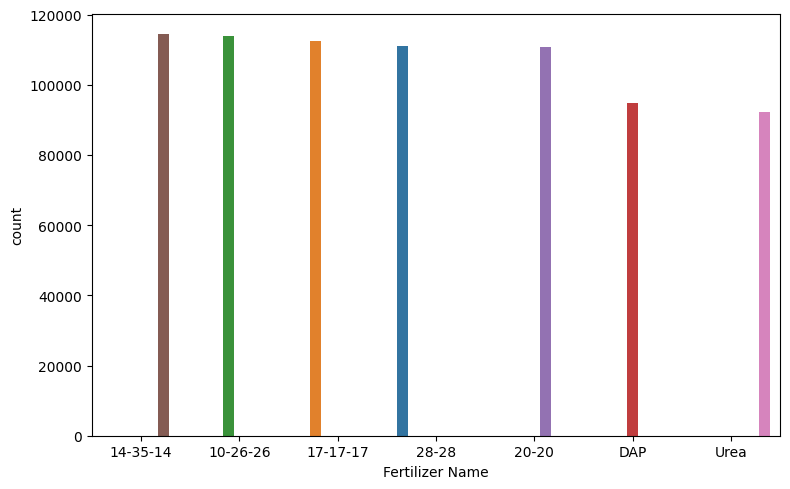

In [22]:
plt.figure(figsize=(8,5))
sns.countplot(x = "Fertilizer Name", hue = "Fertilizer Name", data = train_df,
              order = train_df["Fertilizer Name"].value_counts().index)
plt.gca().get_legend().remove()
plt.tight_layout()
plt.show()

We see again that the set is mostly balanced but DAP and Urea have the smaller proportions of the total.

### Categorical Variables

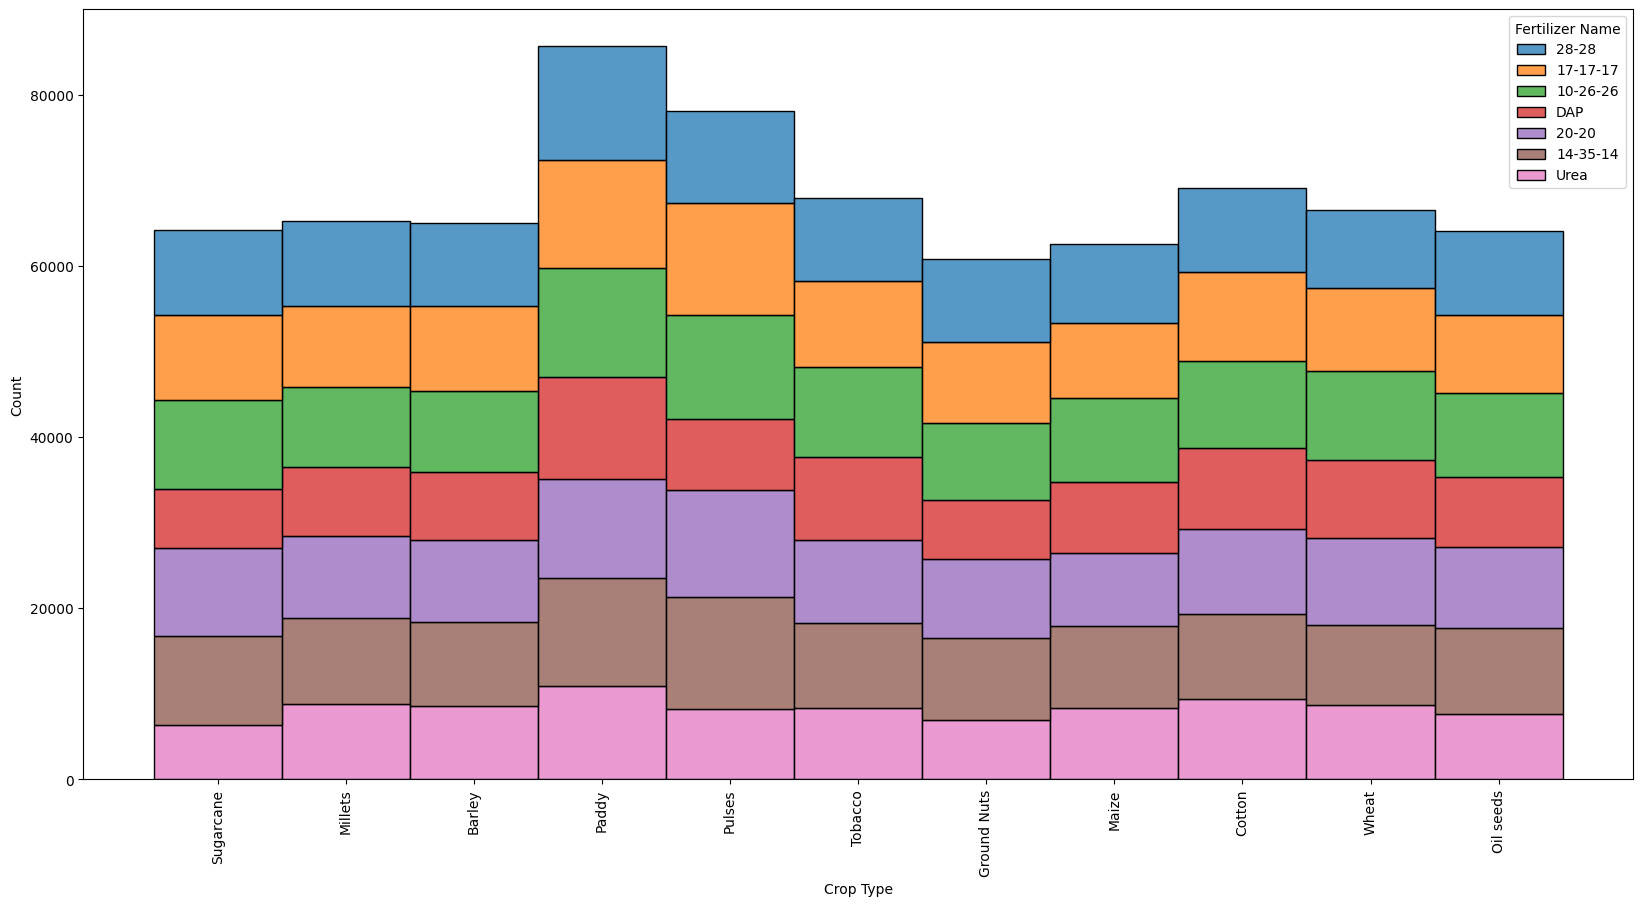

In [23]:
plt.figure(figsize=(20, 10))
sns.histplot(x = "Crop Type", hue="Fertilizer Name", discrete = True,
             multiple = "stack", data = train_df)
plt.xticks(rotation=90)
plt.show()

There are differences in the use of fertilizer per Crop Type. Most pronounced accross the crop types is the limited use of DAP and Urea compared to the other fertilizers

Let's check by percentage

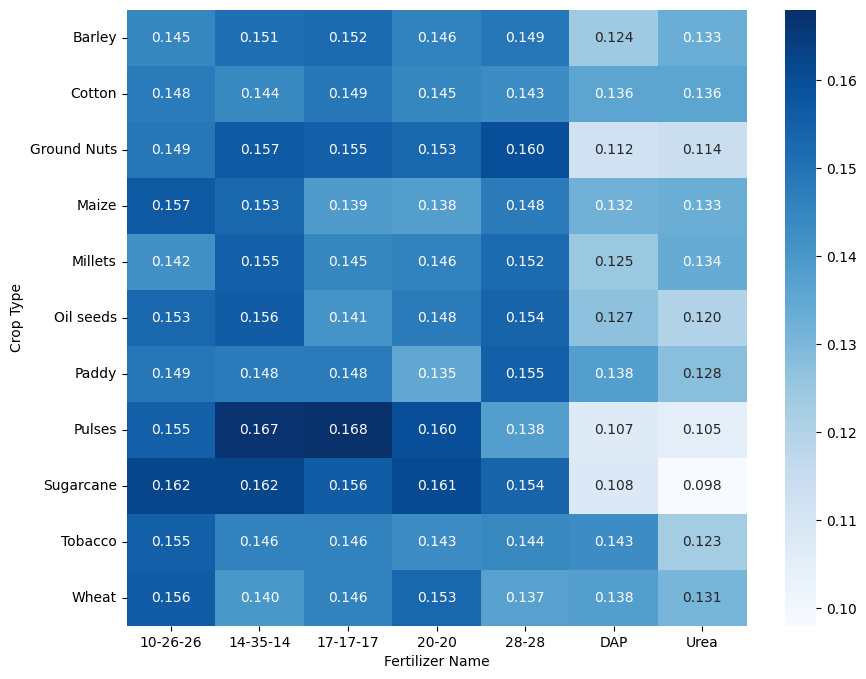

In [24]:
crop_fertilizer_heat_table = train_df.groupby("Crop Type")["Fertilizer Name"]\
.value_counts(normalize=True, dropna= False).apply(lambda x: np.round(x,3))
plt.figure(figsize=(10, 8))
sns.heatmap(crop_fertilizer_heat_table.unstack(), annot=True, fmt=".3f",
            cmap="Blues")
plt.show()

Do the same also for soil type

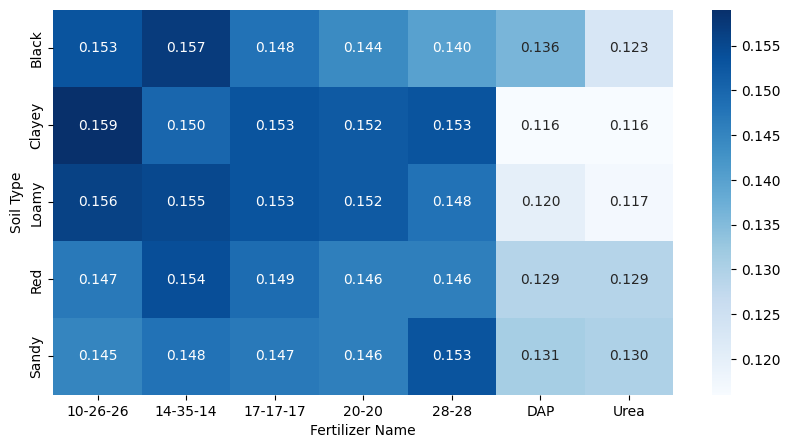

In [25]:
plt.figure(figsize = (10, 5))
soil_fertilizer_heat_table = train_df.groupby("Soil Type")["Fertilizer Name"].\
value_counts(normalize = True, dropna = False).apply(lambda x: np.round(x,3))
sns.heatmap(soil_fertilizer_heat_table.unstack(), annot = True, fmt = ".3f", cmap = "Blues")
plt.show()

There are modest imbalances, but no difference is too pronounced

### Crosstab

In [ ]:
ct = pd.crosstab( # default aggregation = frequency table
    index = [train_df["Soil Type"], train_df["Crop Type"]],
    columns = train_df["Fertilizer Name"],
    normalize = "index" # normalize by each row !!!
)
#ct

In [ ]:
# plt.figure(figsize=(12, 15))
# sns.heatmap(ct, annot=False, cmap="Blues")
# plt.show()

### Numerical Variables

In the following plots we see that conditioning on the Fertilizer name shifts slightly the overall sample statistics.


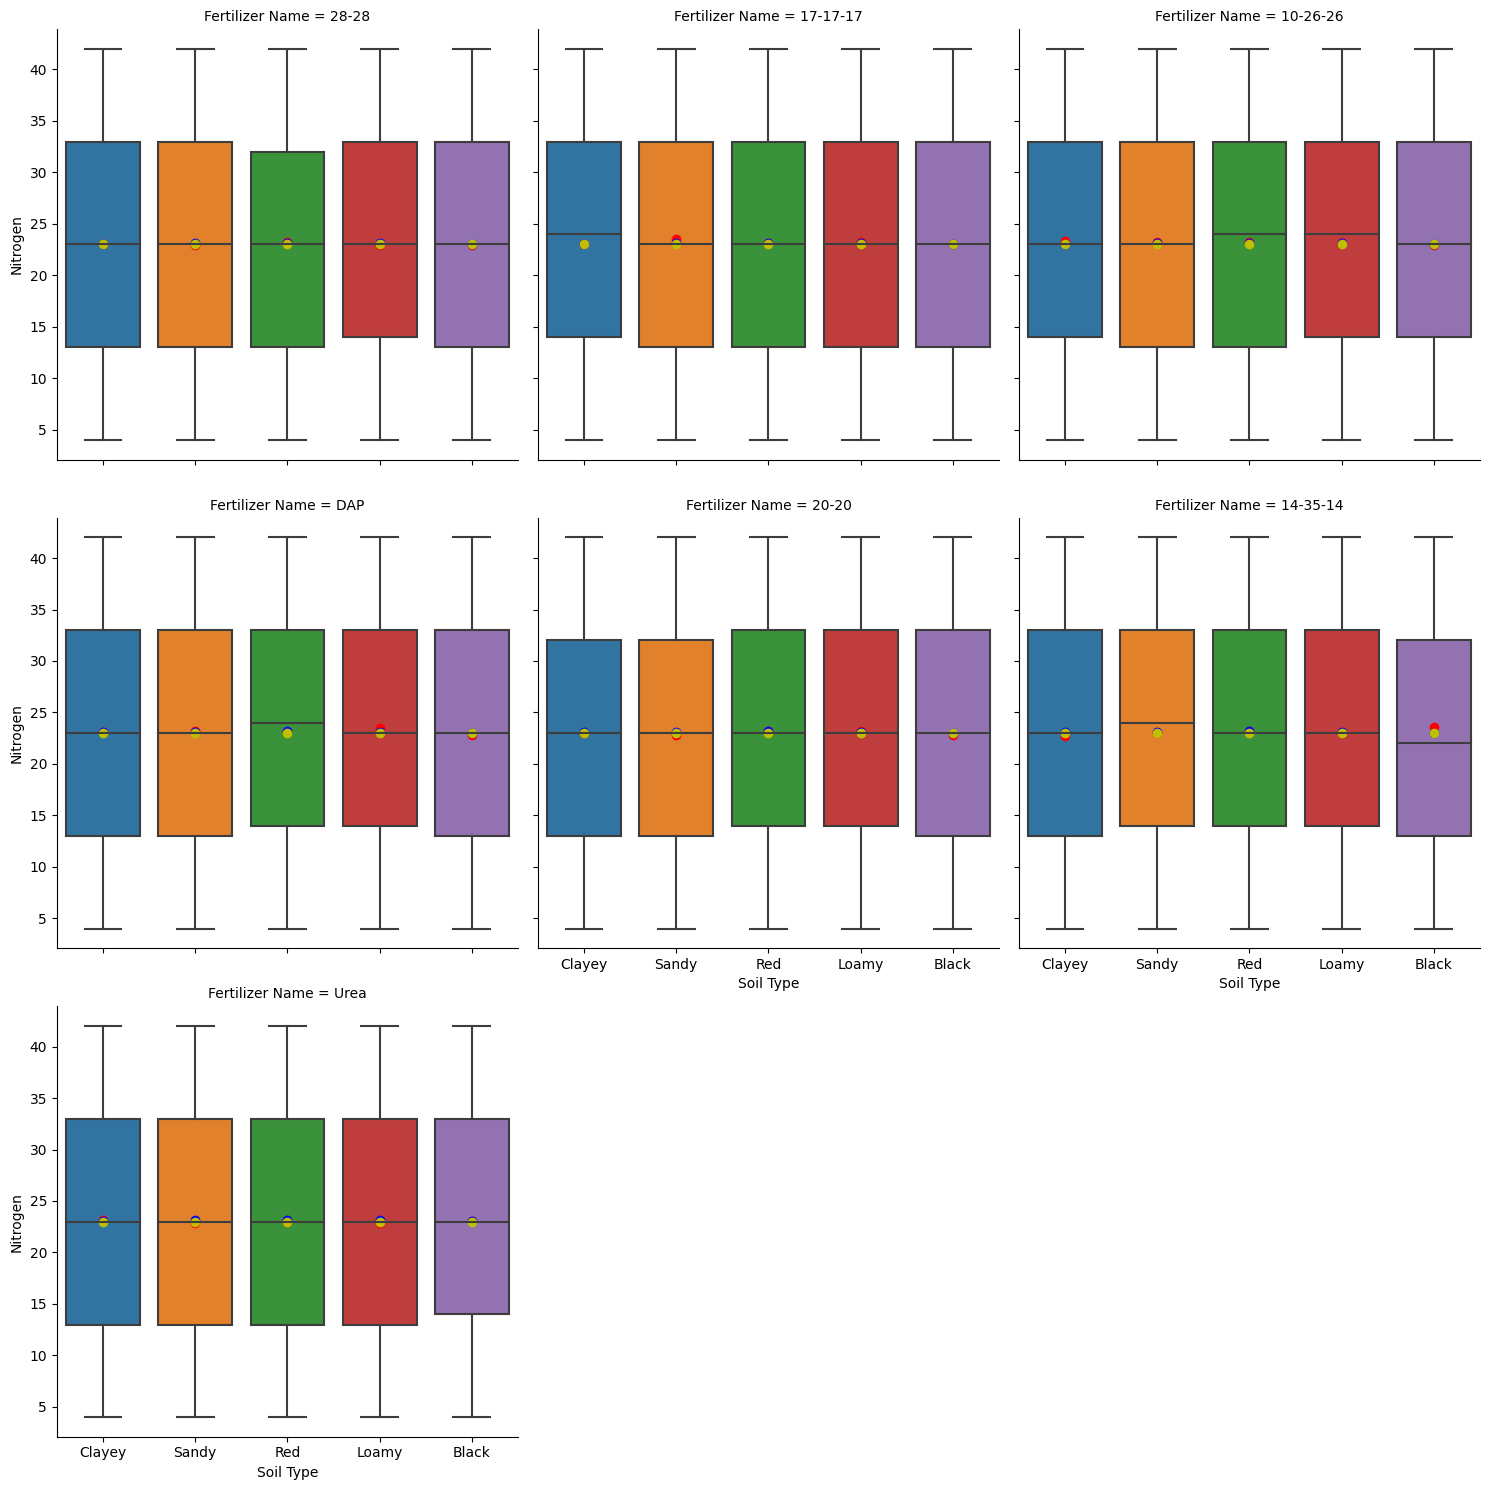

In [26]:
box_n = sns.catplot(data = train_df, x = "Soil Type", y = "Nitrogen", kind = "box",
                   col = "Fertilizer Name", col_wrap=3)
for ax in box_n.axes.flat:
  fertilizer_by_col = ax.title.get_text().split("=")[1].strip()
  ax.plot(train_df[train_df["Fertilizer Name"] == fertilizer_by_col]
          .groupby("Soil Type")["Nitrogen"].mean(), 'ro')
  # overall statistics without the fertilizer grouping
  ax.plot(train_df.groupby("Soil Type")["Nitrogen"].mean(), 'bo')
  ax.plot(train_df.groupby("Soil Type")["Nitrogen"].median(), 'yo')
plt.show()

In [ ]:
boxes_p = sns.catplot(data = train_df, x = "Soil Type", y = "Potassium", kind = "box", col = "Fertilizer Name", col_wrap=3)
for ax in boxes_p.axes.flat:
  fertilizer_by_col = ax.title.get_text().split("=")[1].strip()
  ax.plot(train_df[train_df["Fertilizer Name"] == fertilizer_by_col]
          .groupby("Soil Type")["Potassium"].mean(), 'ro')
  # overall statistics without the fertilizer grouping
  ax.plot(train_df.groupby("Soil Type")["Potassium"].mean(), 'bo')
  ax.plot(train_df.groupby("Soil Type")["Potassium"].median(), 'yo')

In [ ]:
boxes_ph = sns.catplot(data = train_df, x = "Soil Type", y = "Phosphorous", kind = "box", col = "Fertilizer Name", col_wrap=3)
for ax in boxes_ph.axes.flat:
  fertilizer_by_col = ax.title.get_text().split("=")[1].strip()
  ax.plot(train_df[train_df["Fertilizer Name"] == fertilizer_by_col]
          .groupby("Soil Type")["Phosphorous"].mean(), 'ro')
  # overall statistics without the fertilizer grouping
  ax.plot(train_df.groupby("Soil Type")["Phosphorous"].mean(), 'bo')
  ax.plot(train_df.groupby("Soil Type")["Phosphorous"].median(), 'yo')

The same slight differences are observed if we use Crop Type in the X axis

### Feature vs Target

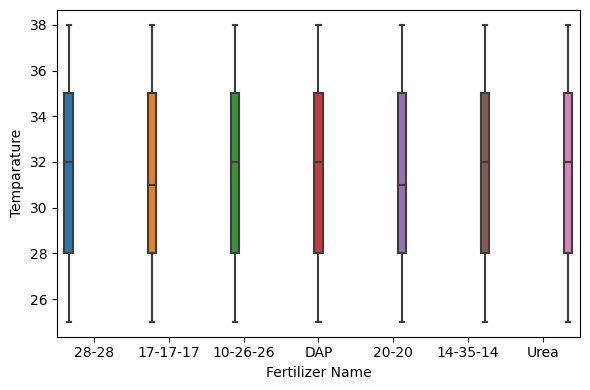

In [27]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Fertilizer Name", y="Temparature", hue="Fertilizer Name", data=train_df)
plt.gca().get_legend().remove()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Fertilizer Name", y="Humidity", hue="Fertilizer Name", data=train_df)
plt.gca().get_legend().remove()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Fertilizer Name", y="Moisture", hue="Fertilizer Name", data=train_df)
plt.gca().get_legend().remove()
plt.tight_layout()
plt.show()

Conditioning on Fertilizer Name seems to somewhat shift the median of the variable 'Temparature'. For the variable "Moisture" the shift is less pronounced. There is an almost imperceptable shift for "Humidity"

Let's check temperature more closely using KDE lines and conditioning on Fertilizer name.
The KDE lines provide a more continuous and generalized view of the underlying temperature probability distribution for each fertilizer type. This helps us understand the typical temperature ranges for each Fertilizer.

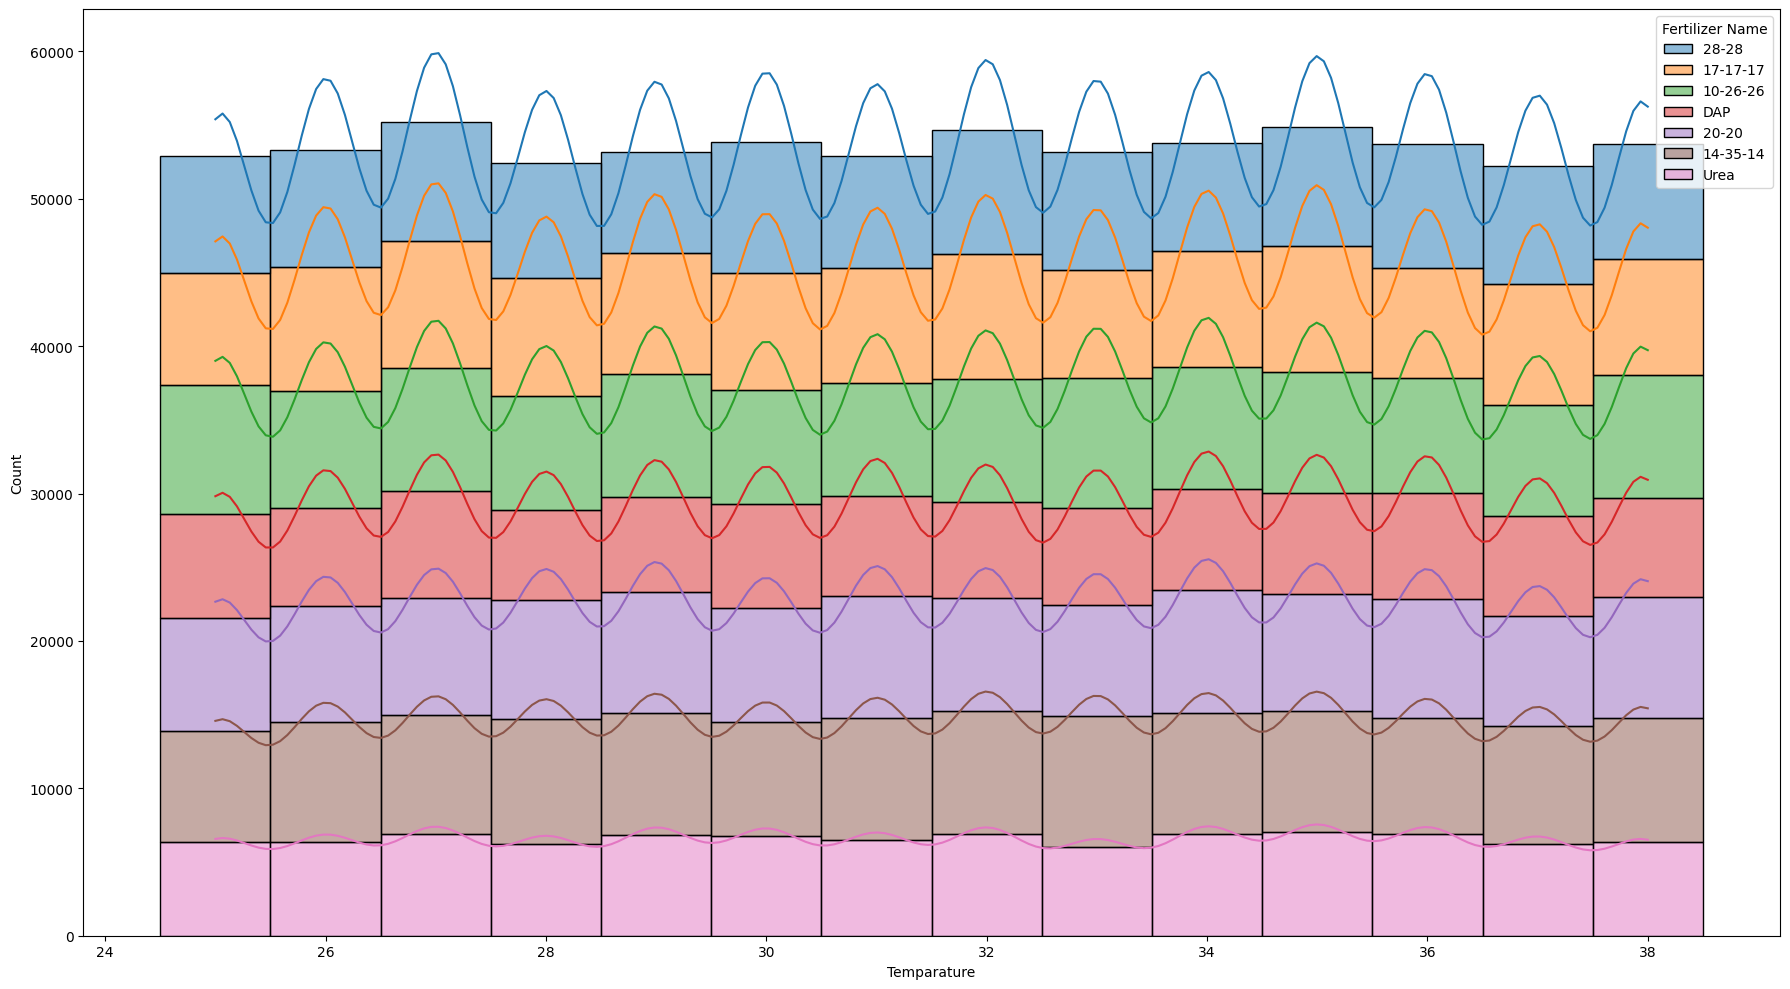

In [28]:
plt.figure(figsize=(18, 10))
sns.histplot(x = "Temparature", hue = "Fertilizer Name", discrete = True,
             multiple = "stack",
             kde = True, data = train_df)
plt.tight_layout()
plt.show()

The KDE lines visually represent the shape of the temperature distribution for each specific fertilizer name. In this way, we can see if a particular fertilizer tends to be used at lower, higher, or a wide range of temperatures. More specifically, peaks in a KDE line indicate temperatures where the corresponding fertilizer name is most concentrated or commonly observed. Valleys indicate less common temperatures. For instance we can see that 28-28 is used more commonly across temperatures compared to Urea.
However, the distribution within each fertilizer name seems to be the same for all temperatures.


Key Take-aways:
1. There are preference patterns, but they are not pronounced.

2. There doesn't seem to be some obvious interaction among the features or between the features and the target.

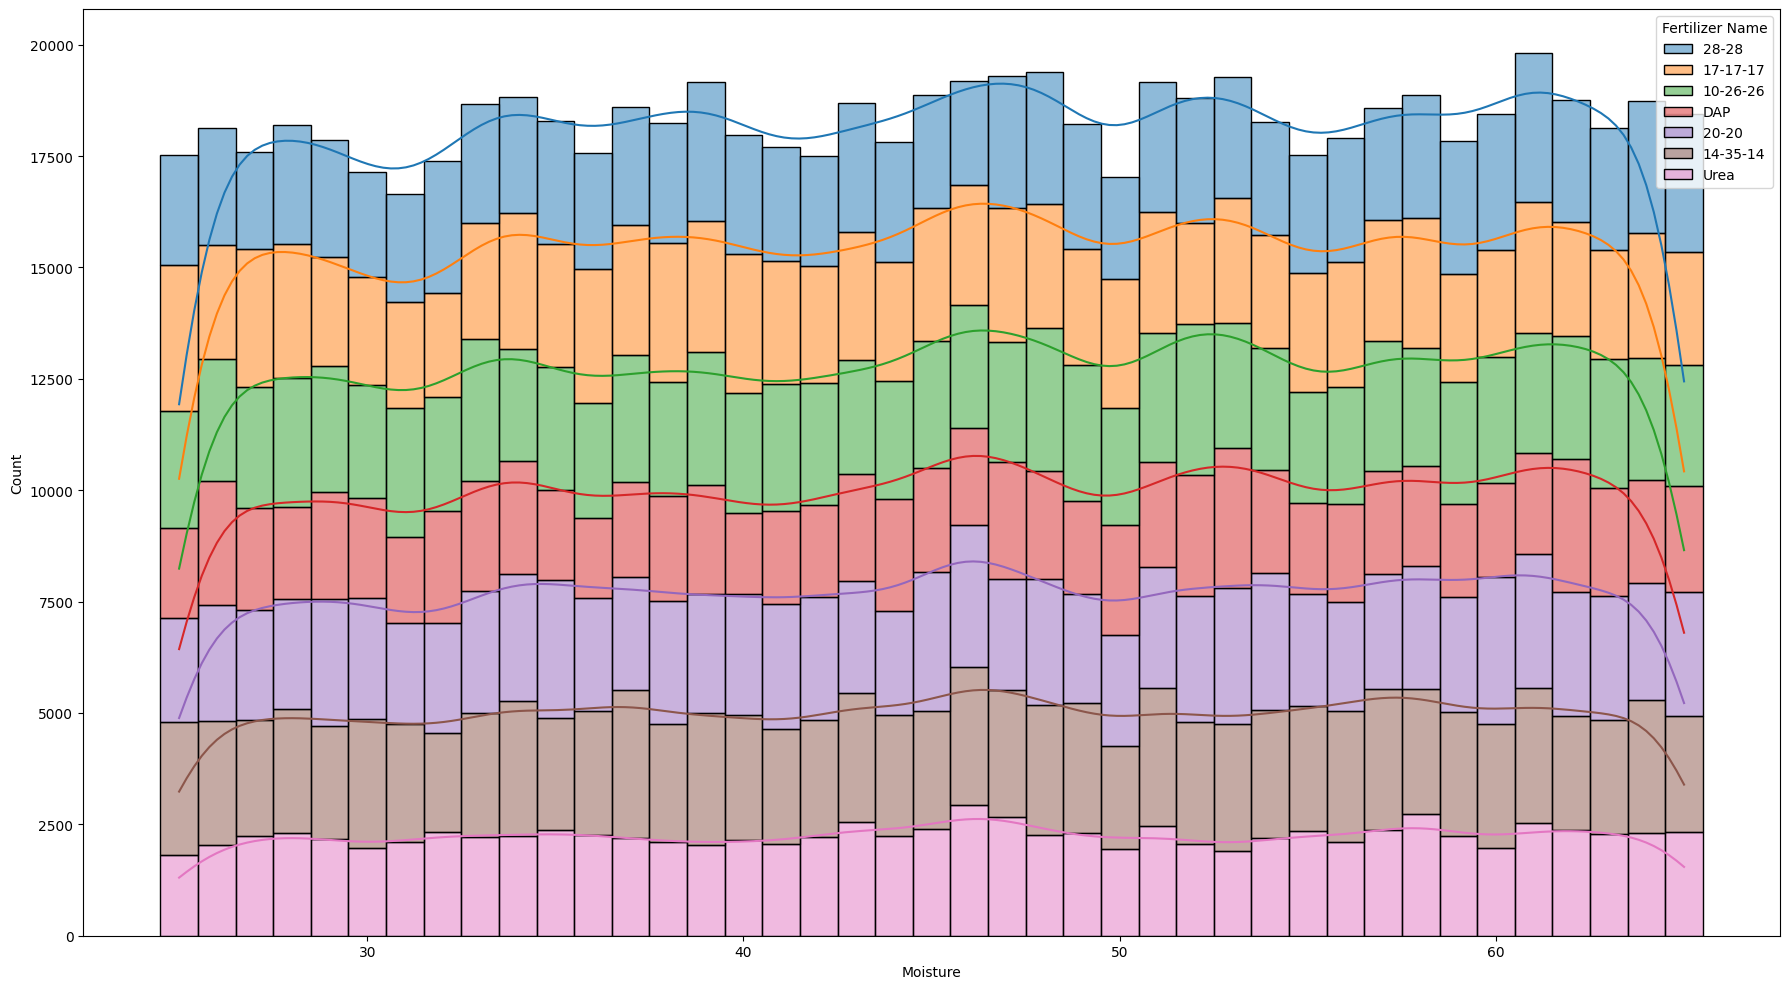

In [29]:
plt.figure(figsize=(18, 10))
sns.histplot(x = "Moisture", hue = "Fertilizer Name", discrete = True,
             multiple = "stack",
             kde = True, data = train_df)
plt.tight_layout()
plt.show()

The KDE lines for each Moisture bin has more pronounced differences within each Fertlizer name. Moisture seems more impactfull than temperature.

We can double check our key takeways by computing the feature utility scores

# Feature Utility Scores (unsupervised)

In [32]:
from sklearn.feature_selection import mutual_info_classif
from pandas.api.types import is_integer_dtype

In [33]:
def make_mi_scores(df, y):
    X = df.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [34]:
X_mi = train_df.copy()
y_mi = X_mi.pop("Fertilizer Name") # unsupervised feature selection
mi_scores = make_mi_scores(X_mi, y_mi)
mi_scores

Moisture       0.003308
Phosphorous    0.002984
Nitrogen       0.002373
Crop Type      0.002088
Potassium      0.001367
Humidity       0.001015
Temparature    0.000966
Soil Type      0.000617
Name: MI Scores, dtype: float64

All scores are very low, but still we can see that moisture is more important the temperature and humidity

# Explore Linear Relationships

In [ ]:
# by default join uses the index of "other"
# features_l = train_df.select_dtypes(include="int64").join(train_df["Fertilizer Name"])
# sns.pairplot(features_l, hue="Fertilizer Name")
# plt.gca().get_legend().remove()
# plt.tight_layout()
# plt.show()

The pair plot is convoluted. No linear relationships can be discerned between the numerical features.

# Plan of Action after EDA:

Since the numerical features are integers with limited ranges, is it worth considering them as **categorical features with high cardinality** and encoding them. For running a *multinomial Logistic Regression model*,it would make sense to one-hot encode these features. <br>
**Handling Non-Linear Relationships**: since the relationship between the integer values and the target is non-linear, one-hot encoding allows the model to capture this without trying to force a linear fit.<br>
**Optimal Partitioning**: for *tree based models* using optimal partitioning for
the high-cardinality discrete numerrical features could be beneficial.


# Clean

We saw in the initial exploration that there are no null values in either set. There are also no duplicates.

In [36]:
def clean(df: pd.DataFrame) \
-> typing.Tuple[pd.DataFrame]:
    col_corrector: function = \
    lambda x : 'temperature' if x.strip() == 'Temparature' else x.strip()
    col_renamer: function = \
    lambda x : "_".join(col_corrector(x).split(" ")).lower()
    df.rename(columns = col_renamer, inplace = True)
    return df

# Data Type encode

Let's make it clear to the models where we are dealing with categories.

In [37]:
features_nom = ["soil_type", "crop_type", "fertilizer_name"]
features_ord = {}
ordered_levels = {key: ["None"] + value for key, value in
                  features_ord.items()}

In [38]:
from pandas.api.types import CategoricalDtype

def encode(df: pd.DataFrame, features_nom = features_nom,
           ordered_levels = ordered_levels) -> pd.DataFrame:
  # nominal features
  for name in features_nom:
    if name not in df.columns:
      continue
    df[name] = df[name].astype("category")
    # if "None" not in df[name].cat.categories:
    #   df[name] = df[name].cat.add_categories("None")
    # ordinal features
  for name, levels in ordered_levels.items():
    if name not in df.columns:
      continue
    df[name] = df[name].astype(CategoricalDtype(categories = levels,
                                                ordered = True))
  return df

# Load

### Data Consistency

Train and Test sets should be conbined in order to be encoded. Otherwise, we have separate encoding schemas

In [48]:
def load() -> typing.Tuple[pd.DataFrame]:
    train = pd.read_csv(paths['train.csv'], index_col = "id", header = 0)
    test = pd.read_csv(paths['test.csv'], index_col = "id", header = 0)
    target = (train.pop('Fertilizer Name')).to_frame()
    df = pd.concat([train, test], axis = 0)
    df = clean(df)
    target = clean(target)
    df = encode(df)
    target = encode(target)
    return df.iloc[train.index, :].join(target), df.iloc[test.index,:]

In [49]:
train, test = load()

# Helper functions for model evaluation

In [40]:
def sort_labels_by_prob(probs: typing.List[float], labels: np.array) -> \
typing.List:
  # Pair the lists and sort based on the ordering_list values (descending)
  paired_lists = zip(labels, probs)
  sorted_pairs = sorted(paired_lists, key=lambda pair: pair[1], reverse=True)
  # Extract the ordered list
  ordered_list = [pair[0] for pair in sorted_pairs]
  return ordered_list

In [41]:
def get_predicted_labels(probs:np.array, classes: np.array)\
 -> np.array:
  predicted_labels = []
  for i in range(probs.shape[0]):
    predicted_labels.append(sort_labels_by_prob(probs[i,:], classes)[0:3])
  return np.array(predicted_labels)

In [42]:
def get_map3_score(true_vals: pd.Series, probs:np.array,
                   classes: np.array) -> int:
  predicted_labels = get_predicted_labels(probs, classes)
  scores = []
  for index, result in enumerate(predicted_labels):
    true_val = true_vals.values[index]
    marked_labels = np.where(result == true_val, 1, 0)
    scores.append(marked_labels @ np.array([1, 1/2, 1/3]))
  return np.mean(scores)

In [43]:
def make_submission_file(probs:np.array, test_df:pd.DataFrame, \
                         classes: np.array):
  # get the id column back
  # test.reset_index(inplace = True)
  y_test = get_predicted_labels(probs, classes)
  y_test_s = [" ".join(item) for item in y_test]
  pd.DataFrame({"id": test_df.index, "Fertilizer Name": y_test_s})\
  .to_csv("submission.csv", index = False)

In [ ]:
def get_cv_score(train_df: pd.DataFrame, target:pd.Series,
                 test: pd.DataFrame, clf:typing.Any, best_params: dict = None) \
 -> typing.Tuple[np.array, np.array, typing.List, typing.List]:

  k_folds = 5

  model_label_encoder = create_label_encoder_instance()
  y_enc = model_label_encoder.fit_transform(target)
  encoder_classes = model_label_encoder.classes_

  oof = np.zeros((train_df.shape[0], encoder_classes.shape[0]))
  test_preds = np.zeros((test.shape[0], encoder_classes.shape[0]))
  scores = []
  models = []

  skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

  for train_indx, val_indx in skf.split(train_df, y_enc):
    X_train_cv, X_val_cv = train_df.iloc[train_indx], train_df.iloc[val_indx]
    y_train_cv, y_val_cv = y_enc[train_indx], y_enc[val_indx]
    #model = XGBClassifier(**xgb_cl_params)
    model = clone(clf)
    if best_params is not None:
        model.set_params(**best_params)
    model.fit(X_train_cv, y_train_cv,
              eval_set=[(X_train_cv, y_train_cv),(X_val_cv, y_val_cv)],
              early_stopping_rounds=100,
             )
    oof[val_indx] = model.predict_proba(X_val_cv)
    scores.append(get_map3_score(target.iloc[val_indx], oof[val_indx],\
                                 encoder_classes))
    test_preds += (model.predict_proba(test) / k_folds)
    models.append(model)
    del model, X_train_cv, y_train_cv, X_val_cv, y_val_cv
    gc.collect()

  return oof, test_preds, scores, encoder_classes, models

This scorer computes the number of times where the correct label is among the top k labels predicted (ranked by predicted scores)

In [45]:
mp3_scorer = metrics.make_scorer(metrics.top_k_accuracy_score, k=3)

# DRY functions

In [46]:
def create_label_encoder_instance() -> LabelEncoder:
  return LabelEncoder()

# Prepared Datasets

In [50]:
X_train = train.copy()
X_test = test.copy()

In [51]:
X_test.head()

,temperature,humidity,moisture,soil_type,crop_type,nitrogen,potassium,phosphorous
id,,,,,,,,
750000,31,70,52,Sandy,Wheat,34,11,24
750001,27,62,45,Red,Sugarcane,30,14,15
750002,28,72,28,Clayey,Ground Nuts,14,15,4
750003,37,53,57,Black,Ground Nuts,18,17,36
750004,31,55,32,Red,Pulses,13,19,14


# Feature Engineering

## Label Encode

A label encoding is okay for any kind of categorical feature when we're using a tree-ensemble like XGBoost, **even for unordered categories**.
If we wanted to try a linear regression model, we would instead want to use a one-hot encoding, especially for the features with unordered categories (Soil Type, Crop Type)

In [52]:
# Label encoding is good for XGBoost and RandomForest, but one-hot
# would be better for models like Lasso or Ridge
def label_encode(df: pd.DataFrame, test:pd.DataFrame = None, \
                 linear = False, drop_target = None) -> typing.Tuple[
                     pd.DataFrame, pd.DataFrame]:
    X = df.copy()
    if drop_target is not None:
        X.pop(drop_target)
    if test is not None:
        X = pd.concat([X, test], axis = 0)
    else:
      test = pd.DataFrame()
    if linear == True:
        df_dummy = pd.get_dummies(X.select_dtypes("category"), dtype = "int",
                              drop_first = True)
        return df_dummy.iloc[df.index, :], df_dummy.iloc[test.index]
    for colname in X.select_dtypes(["category"]):
       # instead of col.factorize to preserve order
        X[colname] = X[colname].cat.codes
    return X.iloc[df.index, :], X.iloc[test.index]

# Naive Model

Naive Bayes performs better with discrete features, like the ones in the dataset

In [38]:
from sklearn import naive_bayes

In [39]:
bayes_features = ['temperature', 'humidity', 'moisture', 'soil_type',
                  'crop_type', 'nitrogen', 'potassium', 'phosphorous',
                  'fertilizer_name']

In [40]:
X_train_bayes = X_train[bayes_features].copy()
y_bayes = X_train_bayes.pop('fertilizer_name')
X_test_bayes = X_test[bayes_features[:-1]].copy()

In [41]:
X_train_bayes, X_test_bayes =  label_encode(X_train_bayes, test = X_test_bayes)

In [42]:
X_test_bayes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   temperature  250000 non-null  int64
 1   humidity     250000 non-null  int64
 2   moisture     250000 non-null  int64
 3   soil_type    250000 non-null  int8 
 4   crop_type    250000 non-null  int8 
 5   nitrogen     250000 non-null  int64
 6   potassium    250000 non-null  int64
 7   phosphorous  250000 non-null  int64
dtypes: int64(6), int8(2)
memory usage: 13.8 MB


In [43]:
X_bayes_train, X_bayes_val, y_bayes_train, y_bayes_val = \
train_test_split(X_train_bayes, y_bayes, test_size = 0.3, stratify = y_bayes, random_state = 0)

In [44]:
nb = naive_bayes.MultinomialNB()
nb.fit(X_bayes_train, y_bayes_train)

MultinomialNB()

### Evaluate on train set

In [45]:
y_bayes_pred_train = nb.predict_proba(X_bayes_train)
get_map3_score(y_bayes_train, y_bayes_pred_train, nb.classes_)

np.float64(0.28005968253968244)

### Evaluate on validation set

In [46]:
y_bayes_pred_val = nb.predict_proba(X_bayes_val)
get_map3_score(y_bayes_val, y_bayes_pred_val, nb.classes_)

np.float64(0.2802392592592593)

Note: there doesn't seem to be a problem with ovefitting

Let's create a confusion matrix to see which classes the naive model got more right than wrong at rank 1.

<Figure size 1500x800 with 0 Axes>

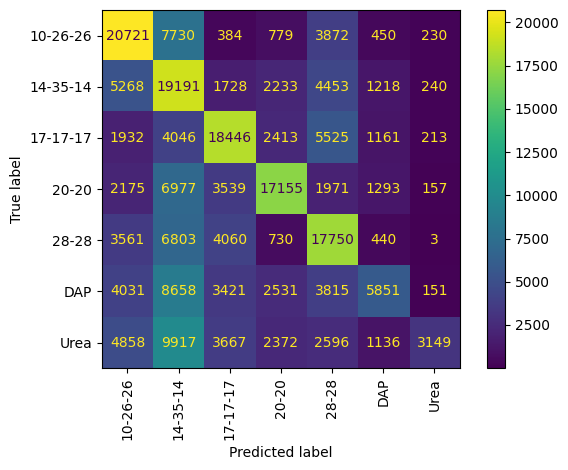

In [47]:
plt.figure(figsize=(15,8))
val_preds = get_predicted_labels(y_bayes_pred_val, nb.classes_)
cm_preds = []
for index,prediction in enumerate(val_preds):
    true_val = y_bayes_val.values[index]
    if true_val in prediction:
        cm_preds.append(true_val)
    else:
        cm_preds.append(prediction[0]) # or whichever other value
cm = metrics.confusion_matrix(y_bayes_val.values, cm_preds, labels = nb.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = nb.classes_)
disp.plot()
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

At rank 1, the naive model mostly misses DAP and Urea, but hits the other labels more than it misses them

# Multiclass (Multinomial) Logistic Regression

Multinomial logistic regression is used when the dependent variable is **nominal**, <br>and falls into any **one** of a set <br>
**of  more than two categories** that cannot be ordered.

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
lr_features = ['temperature', 'humidity', 'moisture', 'soil_type',
                'crop_type', 'nitrogen', 'potassium', 'phosphorous', 'fertilizer_name']

In [73]:
X_train_lr = X_train[lr_features].copy()
X_test_lr = X_test[lr_features[:-1]].copy()

In [74]:
y_lr = X_train_lr.pop("fertilizer_name")
 # we will need the classes so use LabelEncoder
lr_label_encoder = create_label_encoder_instance()
y_lr_enc = lr_label_encoder.fit_transform(y_lr)

In [77]:
X_test_lr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   temperature  250000 non-null  int64
 1   humidity     250000 non-null  int64
 2   moisture     250000 non-null  int64
 3   soil_type    250000 non-null  int8 
 4   crop_type    250000 non-null  int8 
 5   nitrogen     250000 non-null  int64
 6   potassium    250000 non-null  int64
 7   phosphorous  250000 non-null  int64
dtypes: int64(6), int8(2)
memory usage: 13.8 MB


## multicollinearity check

The scatterplots don't reveal any linear relationships.
We can check also the variance inflation factor to detect multicollinearity

In [78]:
# Import variance_inflation_factor from statsmodels.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a subset of the data with the continous independent variables.
X = X_train_lr[['temperature','humidity', 'moisture', 'nitrogen', 'phosphorous',
                'potassium']]

# Calculate the variance inflation factor for each variable.
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Create a DataFrame with the VIF results for the column names in X.
df_vif = pd.DataFrame(vif, index=X.columns, columns = ['VIF'])

# Display the VIF results.
df_vif

,VIF
temperature,39.821013
humidity,43.681898
moisture,14.336672
nitrogen,5.111811
phosphorous,3.845666
potassium,3.641799


There is high multicollinearity when environemental variables are included: <br>
"temperature", "humidity", "moisture"

### Try using all features as categorical and getting the dummies

In [99]:
df_lr = pd.concat([X_train_lr, X_test_lr], axis = 0)
df_lr = encode(df_lr, features_nom = df_lr.columns)
X_train_lrc = df_lr.iloc[X_train_lr.index, :]
X_test_lrc = df_lr.iloc[X_test_lr.index, :]
X_train_lrc, X_test_lrc = label_encode(X_train_lrc, test = X_test_lrc,
                                     linear = True)

## tuning

In [109]:
lr_model = LogisticRegression(
    solver="saga",
    penalty="l1",
    class_weight = "balanced",
    random_state = 42,
    multi_class = 'multinomial')
param_grid = {
    "max_iter": [500, 5000, 10000],
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
mp3_scorer = metrics.make_scorer(metrics.top_k_accuracy_score, k=3)
scoring = {'top-k': mp3_scorer}
# for integer/None values of cv, if the estimator is a classifier,
# then stratifiedKFold is used. Otherwise kFold is used.
cv = GridSearchCV(lr_model, param_grid=param_grid, scoring = scoring, cv=5,
                  refit = 'top-k', n_jobs=-1) #-1 means using all processors

scale the features for logistic regression

In [83]:
# scaler = StandardScaler()
# X_train_lr_scaled = scaler.fit_transform(X_train_lr)
# X_test_lr_scaled = scaler.transform(X_test_lr)

In [ ]:
%%time
# cv.fit(X_train_lr_scaled, y_lr_enc)
cv.fit(X_train_lrc, y_lr)

In [85]:
lr_best_estimator = cv.best_estimator_

In [86]:
cv.best_params_

{'C': 0.001, 'max_iter': 500}

In [ ]:
#lr_model.set_params(**cv.best_params_)

### run cv with best params

In [91]:
# oof_probs, test_probs, scores, encoder_classes, models = get_cv_score(
#     pd.DataFrame(X_train_lr_scaled, columns = X_train_lr.columns), y_lr,
#     pd.DataFrame(X_test_lr_scaled, columns = X_test_lr.columns),
#     lr_model, cv.best_params_)
oof_probs, test_probs, scores, encoder_classes, models = \
get_cv_score(X_train_lrc, y_lr, X_test_lrc, lr_model, cv.best_params_)
overall_Score = get_map3_score(pd.Series(y_lr), oof_probs, encoder_classes)
overall_Score, np.mean(scores)

(np.float64(0.27184244444444433), np.float64(0.27184244444444444))

In [ ]:
y_lr_test_probs = test_probs # np.array(test_preds).mean(axis = 0)
make_submission_file(y_lr_test_probs, X_test, lr_label_encoder.classes_)

# XGBoost

In [53]:
!pip install XGBoost

In [54]:
from xgboost import XGBClassifier, plot_importance, plot_tree, to_graphviz,\
DMatrix, train
from sklearn.pipeline import Pipeline
import shap

Following our observation in the EDA phase, we will create models by encoding all columns as categorical. For the models we will use XGBoost, which we will tune with Optuna. The objective function we will try to maximize is the MAP3 score.

In [55]:
values_to_remove = [
  'id',
  # 'npk_formula',
  # 'fertilizer_nitrogen',
  # 'fertilizer_phosphorous',
  # 'fertilizer_potassium',
  # 'soil_type-crop_type'
 ]
xgb_features = [f for f in X_train.columns.tolist()
 if f not in values_to_remove]

In [56]:
X_train_xgb = X_train[xgb_features].copy()
y_xgb = X_train_xgb.pop("fertilizer_name")
X_test_xgb = X_test[X_train_xgb.columns].copy()

To use categorical data directly with XGBClassifier, first set the type to 'category' then set the parameter 'enable_categorical to True in the class call

In [57]:
xgb_cl_params = dict({
    "objective": "multi:softprob",
    "num_class": y_xgb.unique().shape[0],
    'device': 'gpu' if torch.cuda.is_available() else 'cpu',
    'tree_method': 'gpu_hist' if torch.cuda.is_available() else 'hist',
    'enable_categorical': True,
    'random_state': 42,
    'n_jobs':-1
  })

### Tune and Predict with optuna

In [ ]:
!pip install optuna

In [59]:
import optuna
from functools import partial

Tune

In [60]:
def objective(X:pd.DataFrame, y: pd.Series, useDmatrix: bool,
              trial:optuna.Trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 3, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 100, 300),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.3, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )

    xgb_label_encoder = create_label_encoder_instance()
    y_enc = xgb_label_encoder.fit_transform(y)

    y_pred_train = np.zeros((X.shape[0], xgb_label_encoder.classes_.shape[0]))

    if useDmatrix:
      Xy = DMatrix(X, label = y_enc, enable_categorical=True)
      booster = train({**xgb_cl_params,**xgb_params,
                       "max_cat_to_onehot": 30,
                      },
                      dtrain=Xy)
      y_pred_train = booster.predict(DMatrix(X, enable_categorical=True))
    else:
      xgb = XGBClassifier(**xgb_cl_params)
      xgb.set_params(**xgb_params)
      xgb.fit(X, y_enc)
      #xgb = xgb_pipe.steps[-1][-1]
      y_pred_train = xgb.predict_proba(X)

    return get_map3_score(pd.Series(y), y_pred_train, \
                          xgb_label_encoder.classes_)

In [61]:
def get_optuna_best_params (X:pd.DataFrame, y:pd.Series, useDmatrix = False)\
 -> dict:
  # we want to maximize the objective function
  objective_func = partial(objective, X, y, useDmatrix)
  study = optuna.create_study(direction="maximize")
  study.optimize(objective_func, n_trials=20)
  return study.best_params

### train

In [ ]:
xgb_params = get_optuna_best_params (X_train_xgb, y_xgb)
xgb_params

[I 2025-07-02 08:57:17,729] A new study created in memory with name: no-name-cc20bbbc-65c0-4ad5-855b-c61d38fcf8c1
[I 2025-07-02 08:58:59,513] Trial 0 finished with value: 0.3102522222222222 and parameters: {'max_depth': 5, 'learning_rate': 0.001222232875816071, 'n_estimators': 155, 'min_child_weight': 9, 'colsample_bytree': 0.375672791109557, 'subsample': 0.32833741735246036, 'reg_alpha': 0.13221366590221478, 'reg_lambda': 5.6593236709160735}. Best is trial 0 with value: 0.3102522222222222.
[I 2025-07-02 09:00:28,355] Trial 1 finished with value: 0.3044042222222222 and parameters: {'max_depth': 4, 'learning_rate': 0.0007849646145459216, 'n_estimators': 165, 'min_child_weight': 9, 'colsample_bytree': 0.3006367012141924, 'subsample': 0.20856167418593474, 'reg_alpha': 0.00035938694689656865, 'reg_lambda': 0.05682739115378914}. Best is trial 0 with value: 0.3102522222222222.
[I 2025-07-02 09:03:29,231] Trial 2 finished with value: 0.35707688888888883 and parameters: {'max_depth': 7, 'learn

cv score with tuned model

In [ ]:
#xgb_model = XGBClassifier(**xgb_cl_params)
oof_probs, test_probs, scores, encoder_classes, models = get_cv_score(
    X_train_xgb, y_xgb,X_test_xgb,XGBClassifier(**xgb_cl_params), xgb_params)
overall_Score = get_map3_score(pd.Series(y_xgb), oof_probs, encoder_classes)
overall_Score, np.mean(scores)

In [ ]:
best_model = models[argmax(scores)]

In [ ]:
# Loss curves for the last fold
results = model.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='Train')
plt.plot(results['validation_1']['mlogloss'], label='Val')
plt.legend()
plt.show()

In [ ]:
make_submission_file(test_probs, test, encoder_classes)

### Optimal Partitioning

Optimal partitioning is a technique for partitioning the categorical predictors for each node split.<br>Since we are setting the discrete features as categories we can use optimal partioning<br>
to group categories that lead to similar leaf values<br>
[ref text](https://xgboost.readthedocs.io/en/stable/python/examples/categorical.html)


In [ ]:
X_train_partition = X_train.copy()
X_test_partition = X_test.copy()

In [ ]:
y_partition = X_train_partition.pop("fertilizer_name")
partition_endoder = create_label_encoder_instance()
y_partition_enc = partition_endoder.fit_transform(y_partition)

In [ ]:
features_nom = ['temperature', 'humidity', 'moisture', 'nitrogen',
                'phosphorous', 'potassium']

In [ ]:
df_partition = encode(pd.concat([X_train_partition, X_test_partition], axis = 0))
X_train_partition = df_partition.iloc[X_train_partition.index, :]
X_test_partition = df_partition.iloc[X_test_partition.index, :]

In [ ]:
X_train_partition.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   temperature  750000 non-null  category
 1   humidity     750000 non-null  category
 2   moisture     750000 non-null  category
 3   soil_type    750000 non-null  category
 4   crop_type    750000 non-null  category
 5   nitrogen     750000 non-null  category
 6   potassium    750000 non-null  category
 7   phosphorous  750000 non-null  category
dtypes: category(8)
memory usage: 11.5 MB


In [ ]:
X_test_partition.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   temperature  250000 non-null  category
 1   humidity     250000 non-null  category
 2   moisture     250000 non-null  category
 3   soil_type    250000 non-null  category
 4   crop_type    250000 non-null  category
 5   nitrogen     250000 non-null  category
 6   potassium    250000 non-null  category
 7   phosphorous  250000 non-null  category
dtypes: category(8)
memory usage: 3.8 MB


In [ ]:
xgb_params = get_optuna_best_params (X_train_partition, y_partition, True)
xgb_params

[I 2025-07-01 08:35:59,748] A new study created in memory with name: no-name-03974c7c-0c15-42c1-942b-fb2979af6d17
[I 2025-07-01 08:36:10,970] Trial 0 finished with value: 0.32379688888888875 and parameters: {'max_depth': 7, 'learning_rate': 0.08138769065032116, 'n_estimators': 289, 'min_child_weight': 7, 'colsample_bytree': 0.9786664355235717, 'subsample': 0.25847881866668687, 'reg_alpha': 21.274893389805776, 'reg_lambda': 1.5158950102291506}. Best is trial 0 with value: 0.32379688888888875.
[I 2025-07-01 08:36:23,105] Trial 1 finished with value: 0.385624 and parameters: {'max_depth': 9, 'learning_rate': 0.00018346392510010728, 'n_estimators': 237, 'min_child_weight': 3, 'colsample_bytree': 0.6959403029315876, 'subsample': 0.6486073033722262, 'reg_alpha': 0.0014504629387858035, 'reg_lambda': 0.0003871079960008141}. Best is trial 1 with value: 0.385624.
[I 2025-07-01 08:36:34,634] Trial 2 finished with value: 0.3231822222222222 and parameters: {'max_depth': 9, 'learning_rate': 0.000192

{'max_depth': 10,
 'learning_rate': 0.0007885738370116495,
 'n_estimators': 169,
 'min_child_weight': 3,
 'colsample_bytree': 0.5698160826409262,
 'subsample': 0.6061724590130845,
 'reg_alpha': 0.0031632270331219212,
 'reg_lambda': 0.00014338836784782313}

In [ ]:
xgb_params = {'max_depth': 10,
              'learning_rate': 0.0007885738370116495,
              'n_estimators': 169,
              'min_child_weight': 3,
              'colsample_bytree': 0.5698160826409262,
              'subsample': 0.6061724590130845,
              'reg_alpha': 0.0031632270331219212,
              'reg_lambda': 0.00014338836784782313
              }

In [ ]:
def get_cv_score_with_booster(train_df: pd.DataFrame, target:pd.Series,
                 test: pd.DataFrame, best_params: dict = None) -> \
typing.Tuple[np.array, np.array, typing.List, typing.List, typing.List]:
  k_folds = 5
  model_label_encoder = create_label_encoder_instance()
  y_enc = model_label_encoder.fit_transform(target)
  encoder_classes = model_label_encoder.classes_

  oof = np.zeros((train_df.shape[0], encoder_classes.shape[0]))
  test_preds = np.zeros((test.shape[0], encoder_classes.shape[0]))
  scores = []
  SHAP = []
  models = []
  skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

  for train_indx, val_indx in skf.split(train_df, y_enc):
    X_train_cv, X_val_cv = train_df.iloc[train_indx],\
    train_df.iloc[val_indx]
    y_train_cv, y_val_cv = y_enc[train_indx], y_enc[val_indx]
    #model = XGBClassifier(**xgb_cl_params)

    Xy = DMatrix(X_train_cv, label = y_train_cv, enable_categorical=True)
    booster = train(params = {**xgb_cl_params, **xgb_params,
                              "max_cat_to_onehot": 30}, dtrain = Xy)

    oof[val_indx] = booster.predict(DMatrix(X_val_cv, enable_categorical=True))
    scores.append(get_map3_score(target.iloc[val_indx], oof[val_indx],\
                                  encoder_classes))
    # SHAP.append(booster.predict(DMatrix(X_val_cv, enable_categorical=True),
    #                        pred_contribs=True))

    test_preds += (booster.predict(
        DMatrix(test, enable_categorical= True)) / k_folds)
    models.append(booster)
    #del booster, X_train_cv, y_train_cv, X_val_cv, y_val_cv
    #gc.collect()
  return oof, test_preds, scores, encoder_classes, models

In [ ]:
oof, test_preds, map3_scores, encoder_classes, models = get_cv_score_with_booster(
    X_train_partition, y_partition, X_test_partition, xgb_params)
overall_Score = get_map3_score(pd.Series(y_partition), oof, encoder_classes)
overall_Score, np.mean(map3_scores)

(np.float64(0.31368088888888895), np.float64(0.3136808888888889))

In [ ]:
best_model = models[np.argmax(map3_scores)]

### Tree Explanations

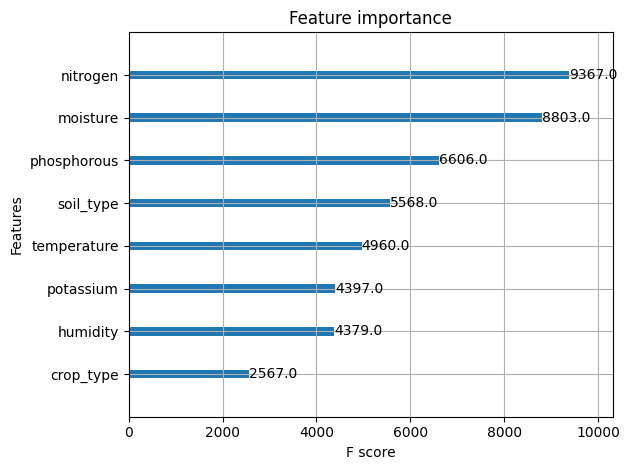

In [ ]:
plot_importance(best_model)
plt.tight_layout()
plt.show()

Get a view of which features are most important for the XGBoost model's predictions, based on the magnitude of their SHAP values across sampled data

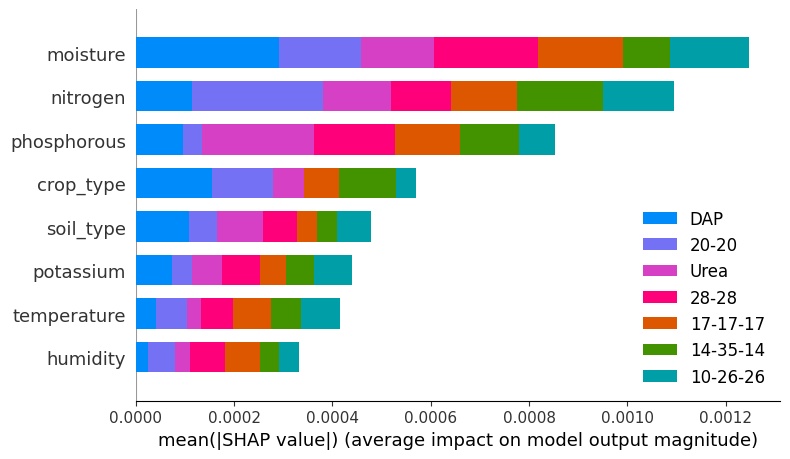

In [ ]:
# Assuming you have a single booster model from your cross-validation loop
# Use the best performing model
explainer = shap.TreeExplainer(best_model)

# Select a sample of the validation data for plotting to avoid long computation
sample_X_val_cv = X_train_partition.sample(n=1000, random_state=42)

# Convert categorical columns to integer codes for SHAP
for col in sample_X_val_cv.select_dtypes(include='category').columns:
    sample_X_val_cv[col] = sample_X_val_cv[col].cat.codes

# Calculate SHAP values for the sample
shap_values = explainer.shap_values(sample_X_val_cv)

# Visualize the feature importance across all instances in the sample
shap.summary_plot(shap_values, sample_X_val_cv, plot_type="bar",
                  class_names=encoder_classes)

# You can also visualize the contribution for a single instance
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0][0,:],
#/sample_X_val_cv.iloc[0,:])

The y-axis of the above plot lists the features in the train dataset, ordered by their overall importance. The horizontal bars represent the average (mean) absolute SHAP value for each feature. The longer the bar, the greater the impact the feature has on the model's output. The length of each bar summarizes the magnitude of the impact, regardless of its direction (positive or negative).

In general, these findings validate the initial EDA on the dataset

One last observation is that phosphorous has the most significant impact in the prediction of Urea, and moisture the most significant impact in predicting DAP.(These are the 2 fertilizers with the most misses).

Lets see which labels the best model hits / misses the most

In [ ]:
predicted_clases = get_predicted_labels(oof, encoder_classes)
predicted_clases

array([['28-28', '17-17-17', '14-35-14'],
       ['28-28', '17-17-17', '20-20'],
       ['28-28', '17-17-17', '14-35-14'],
       ...,
       ['28-28', '14-35-14', '17-17-17'],
       ['20-20', '14-35-14', 'Urea'],
       ['28-28', '10-26-26', '14-35-14']], dtype='<U8')

Rank: 1


<Figure size 1800x600 with 0 Axes>

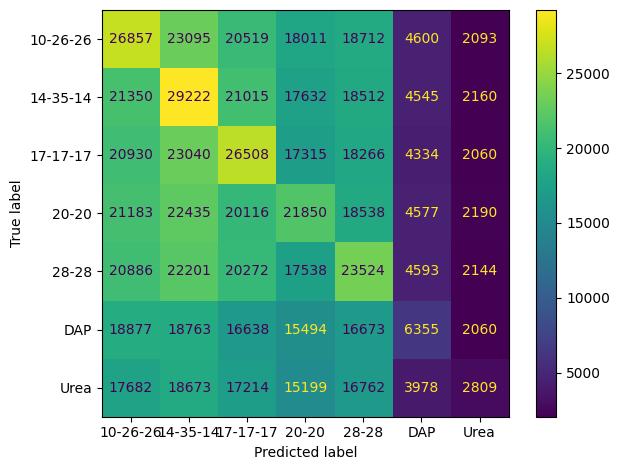

Rank: 2


<Figure size 1800x600 with 0 Axes>

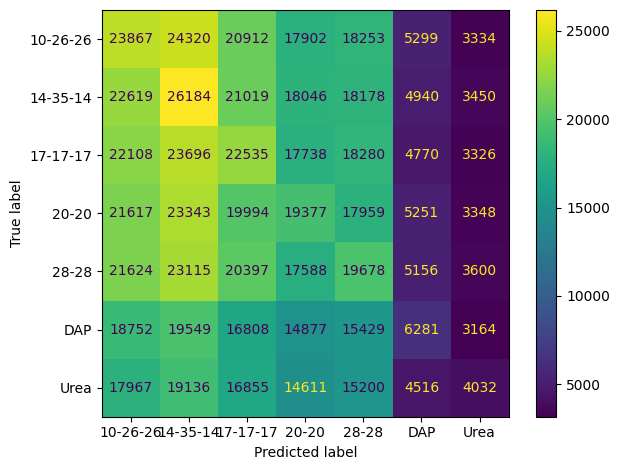

Rank: 3


<Figure size 1800x600 with 0 Axes>

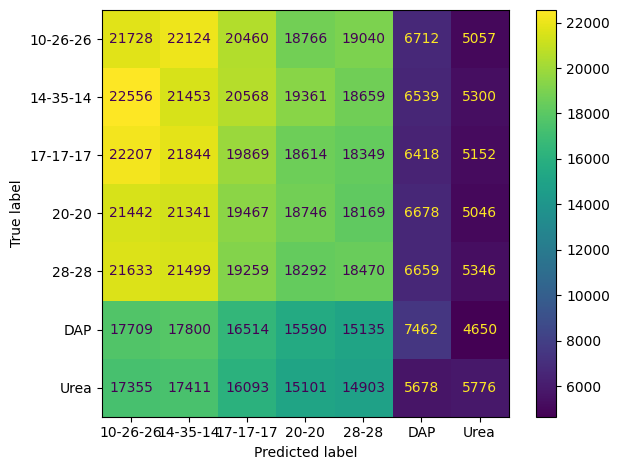

In [ ]:
for i in range(3):
  print(f"Rank: {i+1}")
  plt.figure(figsize=(18,6))

  ranked = predicted_clases[:, i]
  cm = metrics.confusion_matrix(y_partition, ranked, labels = encoder_classes)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, \
                                        display_labels=encoder_classes)
  disp.plot(values_format='')
  plt.tight_layout()
  plt.show()


Again, DAP and UREA have more misses than hits in all ranks

In [ ]:
make_submission_file(test_preds, test, encoder_classes)

In [ ]:
pd.read_csv('./submission.csv')